In [8]:
import sys
import os
sys.path.append('../')

In [9]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from optimizers import AdaIPS_S, IPS
from utils.getData import getData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.t_losses = []
        self.v_losses = []
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [11]:
epochs = 7
batch_size = 64

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])
trainloader, trainset, testloader, testset, validationloader, valset = getData('CIFAR10', transform=transform, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
def train(model, optimizer, epochs=2):
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = epochs
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

    
            # if i % 100 == 0:                
            #     with torch.no_grad():
            #         for v_i, (v_inputs, v_labels) in enumerate(validationloader):
            #             v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
            #             v_outputs = model(v_inputs)
            #             v_loss = criterion(v_outputs, v_labels)
                    
            #         print("validation loss", v_loss.item())                   
            #     model.v_losses.append(v_loss.item())
                
            loss = optimizer.step(closure)
            
            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
                model.t_losses.append(loss.item())
            

    print("Training complete.")
    return model

In [21]:
def test(model, per_class=False):
    model.eval()
    for i, (inputs, labels) in enumerate(testloader):
        with torch.no_grad():
            output = model(inputs)
            output = output.argmax(axis=1)
        
        print("predicted classes:", np.unique(output.detach().numpy()))
        precision, recall, fscore, _ = precision_recall_fscore_support(labels, output.detach().numpy(), average='weighted')
        print(f"accuracy: {accuracy_score(labels, output.detach().numpy())}")
        

        print(f"precision: {precision}\nrecall: {recall}\nfscore: {fscore}")
        if not per_class: 
            return
        
        for i in range(10):
            print(f"Class {i} -> Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {fscore[i]:.4f}")


In [14]:
adaIpsModel = CIFAR10_CNN().to(device)
adaIpsOptimizer = AdaIPS_S(adaIpsModel.parameters())
train(adaIpsModel, adaIpsOptimizer, epochs=epochs)

initialized optimizer with per layer learning rate: False, no T
AdaIPS_S (
Parameter Group 0
    beta_1: 0.9
    beta_2: 0.999
    eps: 1e-08
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.2970757484436035
Epoch 1, Step 100, Loss: 1.842420220375061
Epoch 1, Step 200, Loss: 1.8089308738708496
Epoch 1, Step 300, Loss: 1.6618255376815796
Epoch 1, Step 400, Loss: 1.5433478355407715
Epoch 1, Step 500, Loss: 1.2354081869125366
Epoch 1, Step 600, Loss: 1.4649813175201416
Epoch 2, Step 0, Loss: 1.4268856048583984
Epoch 2, Step 100, Loss: 1.2283453941345215
Epoch 2, Step 200, Loss: 1.152175784111023
Epoch 2, Step 300, Loss: 1.3964967727661133
Epoch 2, Step 400, Loss: 1.3799668550491333
Epoch 2, Step 500, Loss: 1.204188346862793
Epoch 2, Step 600, Loss: 1.0760619640350342
Epoch 3, Step 0, Loss: 1.117795467376709
Epoch 3, Step 100, Loss: 0.9758248925209045
Epoch 3, Step 200, Loss: 1.058148741722107
Epoch 3, Step 300, Loss: 1.0668950080871582
Epoch 3, Step 400, Loss: 0.9486097693443298
Epoch 3, Ste

CIFAR10_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [15]:
adamModel = CIFAR10_CNN().to(device)
adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
train(adamModel, adamOptimizer, epochs=epochs)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.306617259979248
Epoch 1, Step 100, Loss: 1.569997787475586
Epoch 1, Step 200, Loss: 1.4881545305252075
Epoch 1, Step 300, Loss: 1.3523693084716797
Epoch 1, Step 400, Loss: 1.3244916200637817
Epoch 1, Step 500, Loss: 1.3172852993011475
Epoch 1, Step 600, Loss: 1.299784541130066
Epoch 2, Step 0, Loss: 1.3397630453109741
Epoch 2, Step 100, Loss: 0.8721611499786377
Epoch 2, Step 200, Loss: 1.4029529094696045
Epoch 2, Step 300, Loss: 1.1734259128570557
Epoch 2, Step 400, Loss: 0.7669469714164734
Epoch 2, Step 500, Loss: 1.2467434406280518
Epoch 2, Step 600, Loss: 1.1503376960754395
Epoch 3, Step 0, Loss: 0.8826662302017212
Epoch 3, Step 100, Loss: 0.9273289442062378
Epoch 3, Step 200, Loss: 0.7683162689208984
Epoch 3, Step 300, Loss: 0.7857936620712

CIFAR10_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
ipsModel = CIFAR10_CNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), lower_bound=0, T=epochs * (len(trainset)/batch_size))
train(ipsModel, ipsOptimizer, epochs=epochs)

IPS (
Parameter Group 0
    T: 4375.0
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.302015781402588
Epoch 1, Step 100, Loss: 1.910615086555481
Epoch 1, Step 200, Loss: 2.0171751976013184
Epoch 1, Step 300, Loss: 1.4746981859207153
Epoch 1, Step 400, Loss: 1.7717806100845337
Epoch 1, Step 500, Loss: 1.581088662147522
Epoch 1, Step 600, Loss: 1.5190372467041016
Epoch 2, Step 0, Loss: 1.7663358449935913
Epoch 2, Step 100, Loss: 1.548214316368103
Epoch 2, Step 200, Loss: 1.757723093032837
Epoch 2, Step 300, Loss: 1.6019312143325806
Epoch 2, Step 400, Loss: 1.4914294481277466
Epoch 2, Step 500, Loss: 1.4964945316314697
Epoch 2, Step 600, Loss: 1.4831922054290771
Epoch 3, Step 0, Loss: 1.4721629619598389
Epoch 3, Step 100, Loss: 1.5736662149429321
Epoch 3, Step 200, Loss: 1.3346246480941772
Epoch 3, Step 300, Loss: 1.4723228216171265
Epoch 3, Step 400, Loss: 1.4883993864059448
Epoch 3, Step 500, Loss: 1.5330692529678345
Epoch 3, Step 600, Loss: 1.189348816871643
Epoch 4, Step 0, Loss: 1.3798

CIFAR10_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

49
49
49


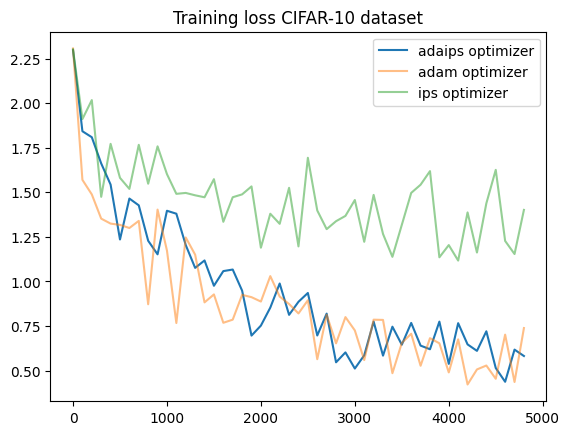

In [20]:

models = [
    (adaIpsModel, 'adaips optimizer'),
    (adamModel, 'adam optimizer'),
    # (adaIpsModel_, 'adaips per param optimizer'),
    
    (ipsModel, 'ips optimizer')

]
exclude = []
focus = [adaIpsModel]
interval = 1
for model, optimizer in models:
    if model in exclude: continue
    print(len(model.t_losses))
    plt.plot(
        [i * 100 for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        [loss for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        label=optimizer,
        alpha=0.5 if model not in focus else 1
    )
plt.title("Training loss CIFAR-10 dataset")
plt.legend()
plt.show()

In [22]:
for model, optimizer in models:
    print(optimizer)
    test(model)
    print('-' * 20, end='\n')

adaips optimizer
predicted classes: [0 1 2 3 4 5 6 7 8 9]
accuracy: 0.7275
precision: 0.7289670041583863
recall: 0.7275
fscore: 0.725602408910698
--------------------
adam optimizer
predicted classes: [0 1 2 3 4 5 6 7 8 9]
accuracy: 0.7282
precision: 0.7304864127035547
recall: 0.7282
fscore: 0.7271870143349867
--------------------
ips optimizer
predicted classes: [0 1 2 3 4 5 6 7 8 9]
accuracy: 0.5594
precision: 0.5580563376728165
recall: 0.5594
fscore: 0.5548512713594722
--------------------


$$
       \begin{aligned}
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{input}      : \gamma \text{ (lr)}, \beta_1, \beta_2
                \text{ (betas)},\theta_0 \text{ (params)},f(\theta) \text{ (objective)}          \\
            &\hspace{13mm}      \lambda \text{ (weight decay)},  \: \textit{amsgrad},
                \:\textit{maximize},  \: \epsilon \text{ (epsilon)}                              \\
            &\textbf{initialize} :  m_0 \leftarrow 0 \text{ ( first moment)},
                v_0\leftarrow 0 \text{ (second moment)},\: v_0^{max}\leftarrow 0          \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\

            &\hspace{5mm}\textbf{if} \: \textit{maximize}:                                       \\
            &\hspace{10mm}g_t           \leftarrow   -\nabla_{\theta} f_t (\theta_{t-1})         \\
            &\hspace{5mm}\textbf{else}                                                           \\
            &\hspace{10mm}g_t           \leftarrow   \nabla_{\theta} f_t (\theta_{t-1})          \\
            &\hspace{5mm}\textbf{if} \: \lambda \neq 0                                           \\
            &\hspace{10mm} g_t \leftarrow g_t + \lambda  \theta_{t-1}                            \\
            &\hspace{5mm}m_t           \leftarrow   \beta_1 m_{t-1} + (1 - \beta_1) g_t          \\
            &\hspace{5mm}v_t           \leftarrow   \beta_2 v_{t-1} + (1-\beta_2) g^2_t          \\
            &\hspace{5mm}\widehat{m_t} \leftarrow   m_t/\big(1-\beta_1^t \big)                   \\
            &\hspace{5mm}\textbf{if} \: amsgrad                                                  \\
            &\hspace{10mm} v_t^{max} \leftarrow \mathrm{max}(v_{t-1}^{max},v_t)                  \\
            &\hspace{10mm}\widehat{v_t} \leftarrow v_t^{max}/\big(1-\beta_2^t \big)              \\
            &\hspace{5mm}\textbf{else}                                                           \\
            &\hspace{10mm}\widehat{v_t} \leftarrow   v_t/\big(1-\beta_2^t \big)                  \\
            &\hspace{5mm}\theta_t \leftarrow \theta_{t-1} - \gamma \widehat{m_t}/
                \big(\sqrt{\widehat{v_t}} + \epsilon \big)                                       \\
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
            &\bf{return} \:  \theta_t                                                     \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
       \end{aligned}
$$